In [5]:
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
import numpy as np
from sklearn.datasets import load_breast_cancer, load_diabetes
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt

def objective_with_pruning(trial):
    X, y = load_breast_cancer(return_X_y=True)
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
    }
    model = GradientBoostingClassifier(**params, random_state=42)
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    scores = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        model.fit(X_train, y_train)
        score = model.score(X_val, y_val)
        scores.append(score)
        trial.report(np.mean(scores), fold)
        if trial.should_prune():
            raise optuna.TrialPruned()
    return np.mean(scores)

study1 = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42),
    pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=1)
)
study1.optimize(objective_with_pruning, n_trials=30, show_progress_bar=True)

print(study1.best_value, study1.best_params)

[I 2025-11-15 16:40:20,894] A new study created in memory with name: no-name-0bd7d591-f61a-42a5-bf31-085241213aaf


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-11-15 16:40:22,932] Trial 0 finished with value: 0.9630836350134596 and parameters: {'n_estimators': 106, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'min_samples_split': 13, 'min_samples_leaf': 2, 'subsample': 0.662397808134481, 'max_features': 'log2'}. Best is trial 0 with value: 0.9630836350134596.
[I 2025-11-15 16:40:25,933] Trial 1 finished with value: 0.9666016894087069 and parameters: {'n_estimators': 156, 'max_depth': 3, 'learning_rate': 0.2708160864249968, 'min_samples_split': 17, 'min_samples_leaf': 3, 'subsample': 0.6727299868828402, 'max_features': None}. Best is trial 1 with value: 0.9666016894087069.
[I 2025-11-15 16:40:26,909] Trial 2 finished with value: 0.9648380209783719 and parameters: {'n_estimators': 115, 'max_depth': 5, 'learning_rate': 0.08012737503998542, 'min_samples_split': 4, 'min_samples_leaf': 3, 'subsample': 0.7465447373174767, 'max_features': 'log2'}. Best is trial 1 with value: 0.9666016894087069.
[I 2025-11-15 16:40:28,002] Trial 3 fin

In [9]:
def multi_objective(trial):
    X, y = load_breast_cancer(return_X_y=True)
    n_estimators = trial.suggest_int('n_estimators', 10, 200)
    max_depth = trial.suggest_int('max_depth', 2, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42,
        n_jobs=-1
    )
    accuracy = cross_val_score(model, X, y, cv=3, scoring='accuracy', n_jobs=-1).mean()
    complexity = n_estimators * max_depth
    return accuracy, complexity

study2 = optuna.create_study(
    directions=['maximize', 'minimize'],
    sampler=TPESampler(seed=42)
)
study2.optimize(multi_objective, n_trials=50, show_progress_bar=True)

for t in study2.best_trials[:3]:
    print(t.number, t.values)

[I 2025-11-15 16:41:34,824] A new study created in memory with name: no-name-c2e1ef2b-26ba-44a8-9ec3-ae576f748c14


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-11-15 16:41:35,937] Trial 0 finished with values: [0.9543117051888982, 1620.0] and parameters: {'n_estimators': 81, 'max_depth': 20, 'min_samples_split': 15}.
[I 2025-11-15 16:41:37,058] Trial 1 finished with values: [0.9543117051888982, 496.0] and parameters: {'n_estimators': 124, 'max_depth': 4, 'min_samples_split': 4}.
[I 2025-11-15 16:41:37,284] Trial 2 finished with values: [0.9543024227234754, 378.0] and parameters: {'n_estimators': 21, 'max_depth': 18, 'min_samples_split': 13}.
[I 2025-11-15 16:41:38,307] Trial 3 finished with values: [0.9402487700733314, 290.0] and parameters: {'n_estimators': 145, 'max_depth': 2, 'min_samples_split': 20}.
[I 2025-11-15 16:41:39,612] Trial 4 finished with values: [0.9543117051888982, 1008.0] and parameters: {'n_estimators': 168, 'max_depth': 6, 'min_samples_split': 5}.
[I 2025-11-15 16:41:40,065] Trial 5 finished with values: [0.9525573192239859, 315.0] and parameters: {'n_estimators': 45, 'max_depth': 7, 'min_samples_split': 11}.
[I 20

In [6]:
class EarlyStoppingCallback:
    def __init__(self, early_stopping_rounds=10, direction='maximize'):
        self.early_stopping_rounds = early_stopping_rounds
        self.direction = direction
        self.best_value = float('-inf') if direction == 'maximize' else float('inf')
        self.counter = 0
    def __call__(self, study, trial):
        if trial.state != optuna.trial.TrialState.COMPLETE:
            return
        v = trial.value
        if self.direction == 'maximize':
            if v > self.best_value:
                self.best_value, self.counter = v, 0
            else:
                self.counter += 1
        else:
            if v < self.best_value:
                self.best_value, self.counter = v, 0
            else:
                self.counter += 1
        if self.counter >= self.early_stopping_rounds:
            study.stop()

def objective_regression(trial):
    X, y = load_diabetes(return_X_y=True)
    alpha = trial.suggest_float('alpha', 1e-3, 10.0, log=True)
    max_iter = trial.suggest_int('max_iter', 100, 2000)
    from sklearn.linear_model import Ridge
    model = Ridge(alpha=alpha, max_iter=max_iter, random_state=42)
    score = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1).mean()
    return -score

early_stopping = EarlyStoppingCallback(early_stopping_rounds=15, direction='minimize')
study3 = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
study3.optimize(objective_regression, n_trials=100, callbacks=[early_stopping], show_progress_bar=True)

print(study3.best_value, study3.best_params)

[I 2025-11-15 16:41:26,857] A new study created in memory with name: no-name-8e9a7dca-12d9-41e0-9651-7a9582113bc7


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-11-15 16:41:29,168] Trial 0 finished with value: 3000.4493286736115 and parameters: {'alpha': 0.03148911647956861, 'max_iter': 1907}. Best is trial 0 with value: 3000.4493286736115.
[I 2025-11-15 16:41:29,218] Trial 1 finished with value: 3347.404998494088 and parameters: {'alpha': 0.8471801418819978, 'max_iter': 1238}. Best is trial 0 with value: 3000.4493286736115.
[I 2025-11-15 16:41:29,251] Trial 2 finished with value: 2994.846179100558 and parameters: {'alpha': 0.004207988669606638, 'max_iter': 396}. Best is trial 2 with value: 2994.846179100558.
[I 2025-11-15 16:41:29,287] Trial 3 finished with value: 2993.3428441817687 and parameters: {'alpha': 0.0017073967431528124, 'max_iter': 1746}. Best is trial 3 with value: 2993.3428441817687.
[I 2025-11-15 16:41:29,325] Trial 4 finished with value: 3055.2093598335728 and parameters: {'alpha': 0.2537815508265665, 'max_iter': 1446}. Best is trial 3 with value: 2993.3428441817687.
[I 2025-11-15 16:41:29,354] Trial 5 finished with val

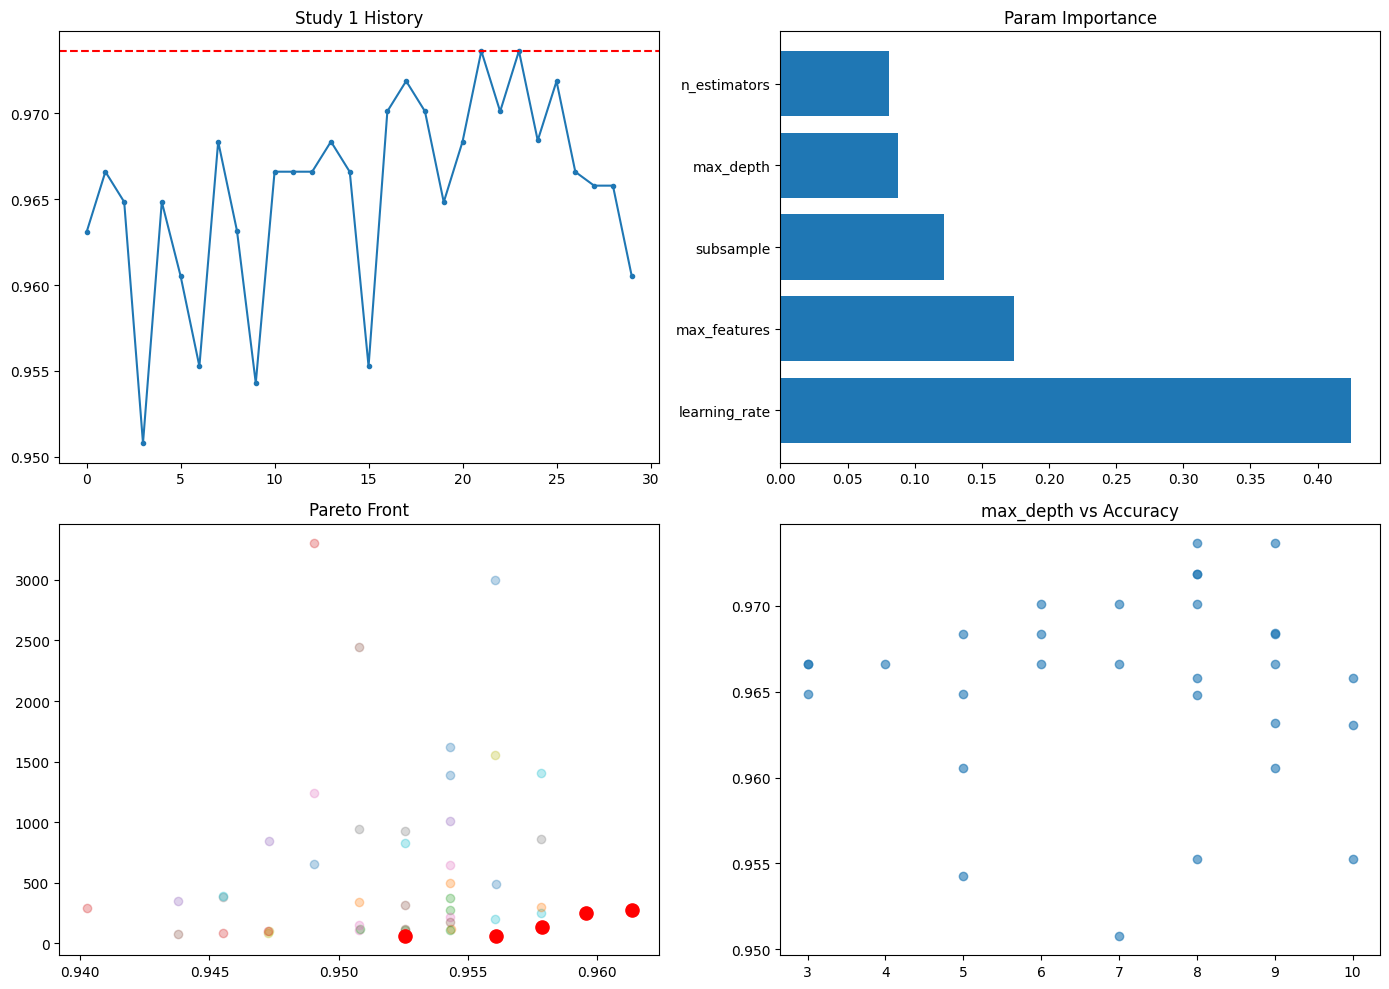

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

ax = axes[0, 0]
values = [t.value for t in study1.trials if t.value is not None]
ax.plot(values, marker='o', markersize=3)
ax.axhline(y=study1.best_value, color='r', linestyle='--')
ax.set_title('Study 1 History')

ax = axes[0, 1]
importance = optuna.importance.get_param_importances(study1)
params = list(importance.keys())[:5]
vals = [importance[p] for p in params]
ax.barh(params, vals)
ax.set_title('Param Importance')

ax = axes[1, 0]
for t in study2.trials:
    if t.values:
        ax.scatter(t.values[0], t.values[1], alpha=0.3)
for t in study2.best_trials:
    ax.scatter(t.values[0], t.values[1], c='red', s=90)
ax.set_title('Pareto Front')

ax = axes[1, 1]
pairs = [(t.params.get('max_depth', 0), t.value) for t in study1.trials if t.value]
Xv, Yv = zip(*pairs) if pairs else ([], [])
ax.scatter(Xv, Yv, alpha=0.6)
ax.set_title('max_depth vs Accuracy')

plt.tight_layout()
plt.savefig('optuna_analysis.png', dpi=150)
plt.show()

In [8]:
p1 = len([t for t in study1.trials if t.state == optuna.trial.TrialState.PRUNED])
print("Study 1 Best Accuracy:", study1.best_value)
print("Study 1 Pruned %:", p1 / len(study1.trials) * 100)

print("Study 2 Pareto Solutions:", len(study2.best_trials))

print("Study 3 Best MSE:", study3.best_value)
print("Study 3 Trials:", len(study3.trials))

Study 1 Best Accuracy: 0.9736377981992016
Study 1 Pruned %: 26.666666666666668
Study 2 Pareto Solutions: 5
Study 3 Best MSE: 2993.068591506391
Study 3 Trials: 53
